Importando bibliotecas necessárias para o modelo de XGBoost Classifier

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import pickle

Lendo arquivo .csv (Synthetic_Financial_datasets_log)

In [ ]:
df = pd.read_csv("Synthetic_Financial_datasets_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Realizando limpeza de valores nulos

In [ ]:
df = df.dropna(subset=[
    'step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest', 'isFraud'
])
df.shape

(6362620, 11)

Codificando variáveis categóricas

In [ ]:
le_type = LabelEncoder()
df['type_encoded'] = le_type.fit_transform(df['type'])

Criando variáveis derivadas

In [ ]:
df['isMerchant'] = df['nameDest'].astype(str).str.startswith('M').astype(int)

Selecionando features e target

In [ ]:
features = ['step', 'type_encoded', 'amount', 'isMerchant']
X = df[features]
y = df['isFraud']

Divisão dos dados entre treinamento e teste

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

In [ ]:
X_train.shape

(4072076, 4)

In [ ]:
X_test.shape

(1272524, 4)

Treinando o modelo XGBoost Classifier (SEM SMOTE)

In [ ]:
xgb_sem_smote = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_sem_smote.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

Realizando previsões (SEM SMOTE)

In [ ]:
y_test_pred_sem = xgb_sem_smote.predict(X_test)
y_test_proba_sem = xgb_sem_smote.predict_proba(X_test)[:, 1]

Avaliando desempenho do modelo (SEM SMOTE)

In [ ]:
print("\nRelatório de Classificação (SEM SMOTE):")
print(classification_report(y_test, y_test_pred_sem))
print("Matriz de Confusão (SEM SMOTE):")
print(confusion_matrix(y_test, y_test_pred_sem))
roc_auc_sem = roc_auc_score(y_test, y_test_proba_sem)
print(f"AUC-ROC (SEM SMOTE): {roc_auc_sem:.4f}")


Relatório de Classificação (SEM SMOTE):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.81      0.19      0.30      1620

    accuracy                           1.00   1272524
   macro avg       0.91      0.59      0.65   1272524
weighted avg       1.00      1.00      1.00   1272524

Matriz de Confusão (SEM SMOTE):
[[1270834      70]
 [   1319     301]]
AUC-ROC (SEM SMOTE): 0.9446


Visualização das previsões (SEM SMOTE)

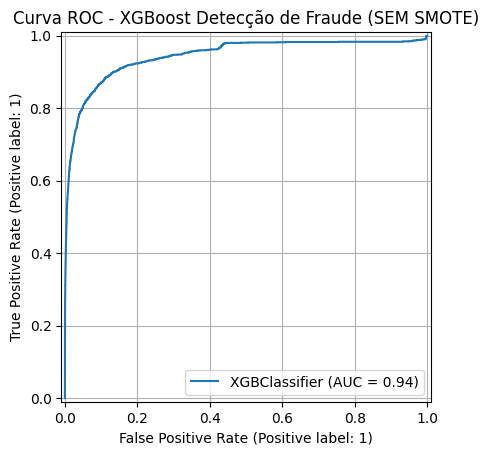

In [ ]:
RocCurveDisplay.from_estimator(xgb_sem_smote, X_test, y_test)
plt.title("Curva ROC - XGBoost Detecção de Fraude (SEM SMOTE)")
plt.grid(True)
plt.show()

Aplicando SMOTE nos dados de treino

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Treinando o modelo XGBoost Classifier (COM SMOTE)

In [ ]:
xgb_com_smote = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_com_smote.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

Encontrando threshold ideal (baseado em F1-score)

In [ ]:
y_val_proba = xgb_com_smote.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)

if best_idx >= len(thresholds):
    best_idx = len(thresholds) - 1

best_threshold = thresholds[best_idx]

Realizando previsões (COM SMOTE)

In [ ]:
y_test_proba = xgb_com_smote.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

Avaliando desempenho do modelo (COM SMOTE)

In [ ]:
print("\nRelatório de Classificação (COM SMOTE):")
print(classification_report(y_test, y_test_pred))
print("Matriz de Confusão (COM SMOTE):")
print(confusion_matrix(y_test, y_test_pred))
roc_auc_smote = roc_auc_score(y_test, y_test_proba)
print(f"AUC-ROC (COM SMOTE): {roc_auc_smote:.4f}")


Relatório de Classificação (COM SMOTE):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.57      0.36      0.44      1620

    accuracy                           1.00   1272524
   macro avg       0.78      0.68      0.72   1272524
weighted avg       1.00      1.00      1.00   1272524

Matriz de Confusão (COM SMOTE):
[[1270453     451]
 [   1031     589]]
AUC-ROC (COM SMOTE): 0.9650


Visualização das previsões (COM SMOTE)

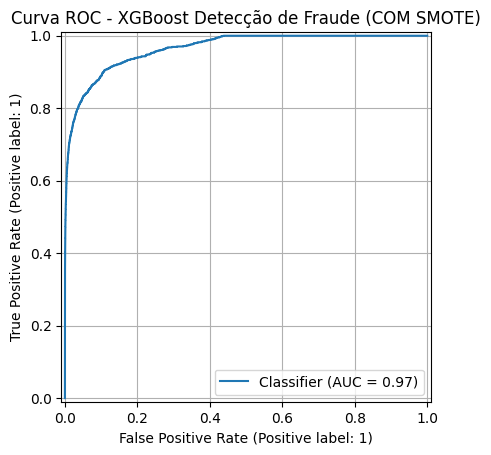

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("Curva ROC - XGBoost Detecção de Fraude (COM SMOTE)")
plt.grid(True)
plt.show()

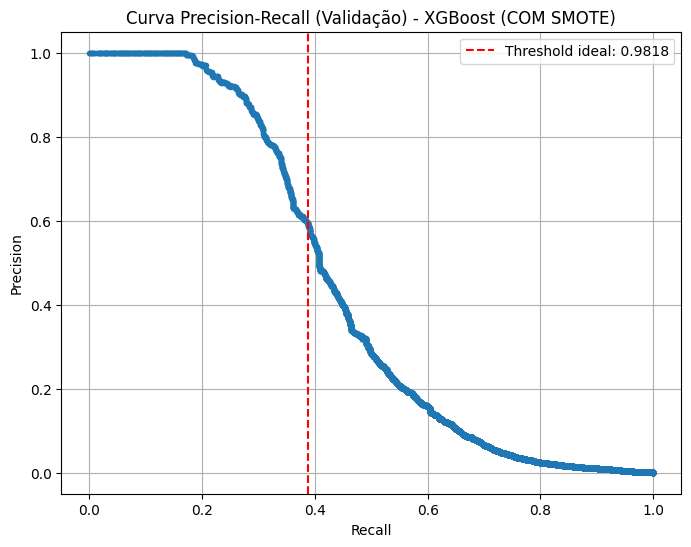

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.axvline(recall[best_idx], color='r', linestyle='--',
            label=f'Threshold ideal: {best_threshold:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall (Validação) - XGBoost (COM SMOTE)")
plt.legend()
plt.grid(True)
plt.show()

Salvando o modelo e encoder com Pickle

In [ ]:
with open('modelo_xgboost_fraude.pkl', 'wb') as file_model:
    pickle.dump(xgb_com_smote, file_model)

with open('label_encoder_type_classes.pkl', 'wb') as f:
    pickle.dump(le_type.classes_.tolist(), f)

with open('best_threshold.pkl', 'wb') as file_thresh:
    pickle.dump(best_threshold, file_thresh)

print("Modelo XGBoost, Encoder e Threshold para detecção de fraude salvos com sucesso!")

Modelo XGBoost, Encoder e Threshold para detecção de fraude salvos com sucesso!


# Comparação SEM SMOTE vs COM SMOTE

O modelo sem SMOTE mostra desempenho quase perfeito na classe majoritária, mas falha em identificar a classe minoritária, resultando em baixo recall e F1-score. Já o modelo com SMOTE sacrifica parte da precisão da classe majoritária, mas melhora significativamente a detecção da classe rara, elevando o recall, o F1-score e o AUC-ROC. Assim, o uso do SMOTE torna o modelo mais equilibrado e adequado em cenários onde é essencial reconhecer eventos raros, mesmo que isso implique em mais falsos positivos.